# FrequencySeries の新機能と高度な操作

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/intro_frequencyseries.ipynb)

このノートブックでは、`gwexpy` で拡張された `FrequencySeries` クラスの新しいメソッドと機能について紹介します。
主に複素スペクトルの扱い、微積分、フィルタリング（スムージング）、および他ライブラリとの連携機能に焦点を当てます。

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.frequencyseries import FrequencySeries
from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries

plt.rcParams["figure.figsize"] = (10, 6)

## 1. データの準備

まずは `TimeSeries` から FFT を用いて `FrequencySeries` を作成します。
ここでは、特定の周波数成分を持つテスト信号を生成します。

TimeSeries([-0.02975679,  0.45334007,  0.03332861, ...,
             1.27671368,  1.01325371,  0.65455846]
           unit: um,
           t0: 0.0 s,
           dt: 0.0009765625 s,
           name: Test Signal,
           channel: None)


Type: <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'>
Length: 3073
df: 0.16666666666666666 Hz


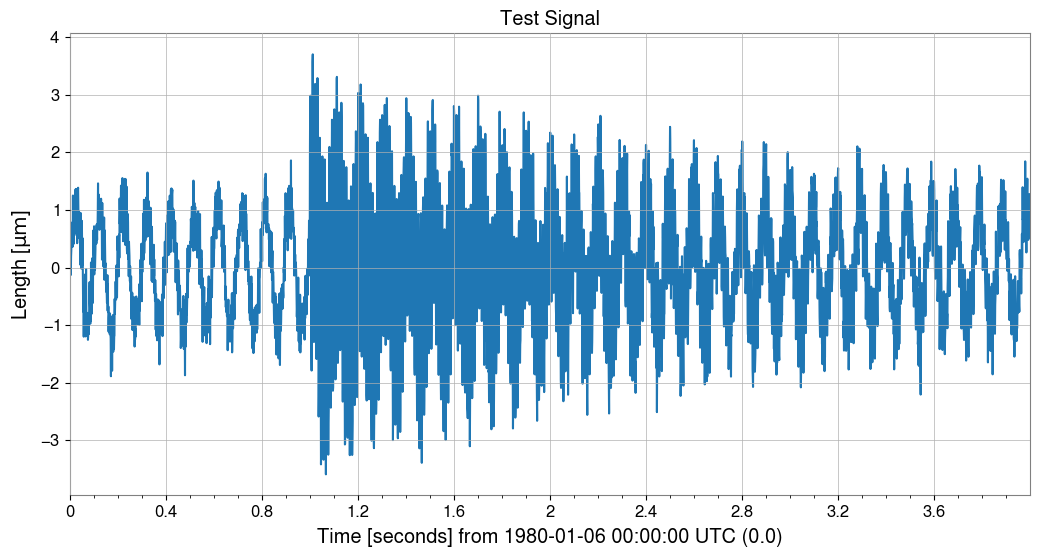

In [2]:
fs = 1024
t = np.arange(0, 4, 1 / fs)
exp = np.exp(-t / 1.5)
exp[: int(exp.size / 4)] = 0
data = (
    np.sin(2 * np.pi * 10.1 * t)
    + 5 * exp * np.sin(2 * np.pi * 100.1 * t)
    + np.random.normal(scale=0.3, size=len(t))
)
ts = TimeSeries(data, dt=1 / fs, unit="um", name="Test Signal")
print(ts)
ts.plot(title=ts.name)

# FFT を実行して FrequencySeries を取得 (transient モードを使用してパディングを適用)
spec = ts.fft(mode="transient", pad_left=1.0, pad_right=1.0, nfft_mode="next_fast_len")
print(f"Type: {type(spec)}")
print(f"Length: {len(spec)}")
print(f"df: {spec.df}")

## 2. 複素スペクトルの可視化と変換

### 位相と振幅
`phase()`, `degree()`, `to_db()` メソッドを使用すると、複素スペクトルを直感的な単位に変換できます。

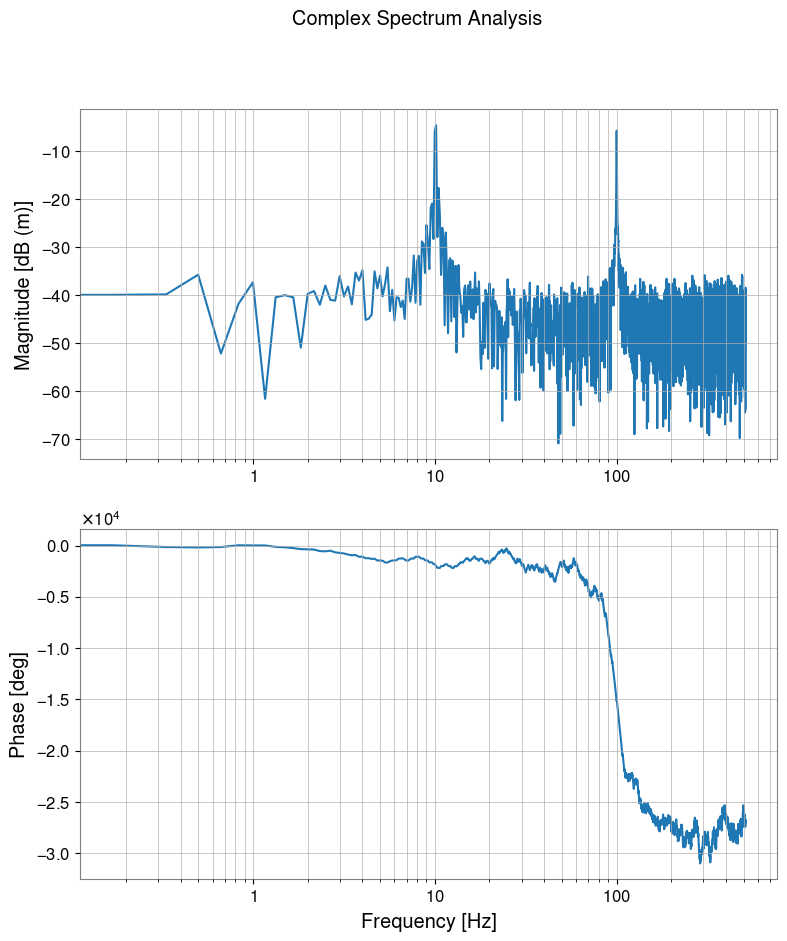

In [3]:
# 振幅を dB に変換 (ref=1.0, 20*log10)
spec_db = spec.to_db()

# 位相を取得 (度数表記、unwrap=True で連続化)
spec_phase = spec.degree(unwrap=True)

plot = Plot(spec_db, spec_phase, separate=True, sharex=True, xscale="log")
ax = plot.axes
ax[0].set_ylabel("Magnitude [dB (m)]")
ax[0].grid(True, which="both")

ax[1].set_ylabel("Phase [deg]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid(True, which="both")
plot.figure.suptitle("Complex Spectrum Analysis")
plot.show()

## 3. 周波数ドメインでの微積分

`differentiate()` および `integrate()` メソッドにより、周波数ドメインで微分・積分を行うことができます。
引数 `order` で階数を指定できます（デフォルトは1）。
これは「変位・速度・加速度」の変換（$(2 \pi i f)^n$ の乗算・除算）を簡単に行うための機能です。

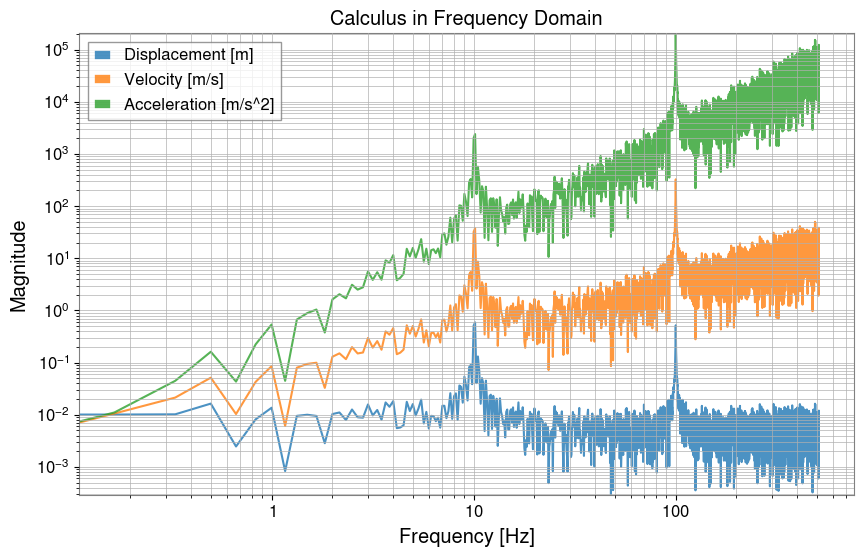

In [4]:
# 変位 (m) -> 速度 (m/s) に微分 (order=1)
vel_spec = spec.differentiate()

# 変位 (m) -> 加速度 (m/s^2) に 2回微分 (order=2)
accel_spec = spec.differentiate(order=2)

# 積分も可能: 加速度 -> 速度
vel_from_accel = accel_spec.integrate()

plot = Plot(
    spec.abs(), vel_spec.abs(), accel_spec.abs(), xscale="log", yscale="log", alpha=0.8
)
ax = plot.gca()
ax.get_lines()[0].set_label("Displacement [m]")
ax.get_lines()[1].set_label("Velocity [m/s]")
ax.get_lines()[2].set_label("Acceleration [m/s^2]")
ax.legend()
ax.grid(True, which="both")
ax.set_title("Calculus in Frequency Domain")
ax.set_ylabel("Magnitude")
plot.show()

## 4. スペクトルのスムージングとピーク検出

### スムージング
`smooth()` メソッドを使用すると、移動平均などによるスペクトルの平滑化が可能です。

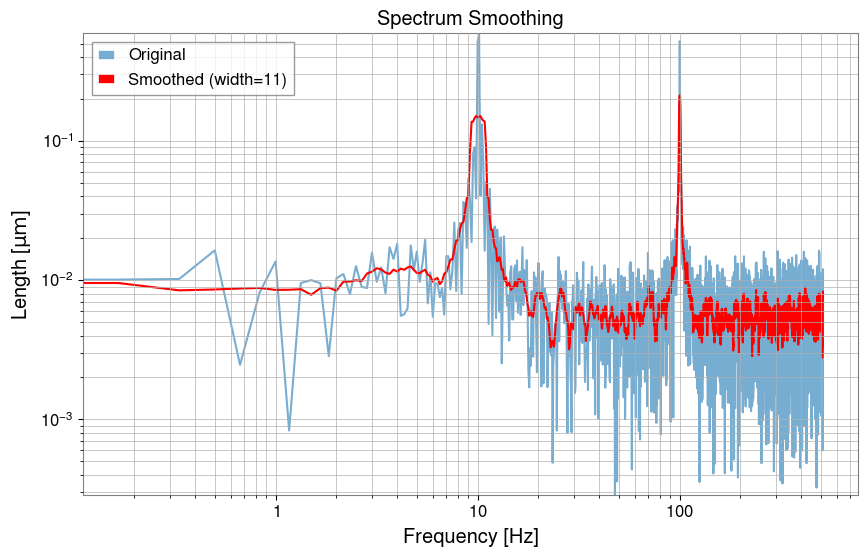

In [5]:
# 振幅ドメインで 11 サンプルのスムージング
spec_smooth = spec.smooth(width=11)

plot = Plot(spec.abs(), spec_smooth.abs(), xscale="log", yscale="log")
ax = plot.gca()
ax.get_lines()[0].set_label("Original")
ax.get_lines()[0].set_alpha(0.6)
ax.get_lines()[1].set_label("Smoothed (width=11)")
ax.get_lines()[1].set_color("red")
ax.legend()
ax.grid(True, which="both")
ax.set_title("Spectrum Smoothing")
plot.show()

### ピーク検出
`find_peaks()` メソッドは `scipy.signal.find_peaks` をラップしており、特定の閾値を超えるピークを簡単に抽出できます。

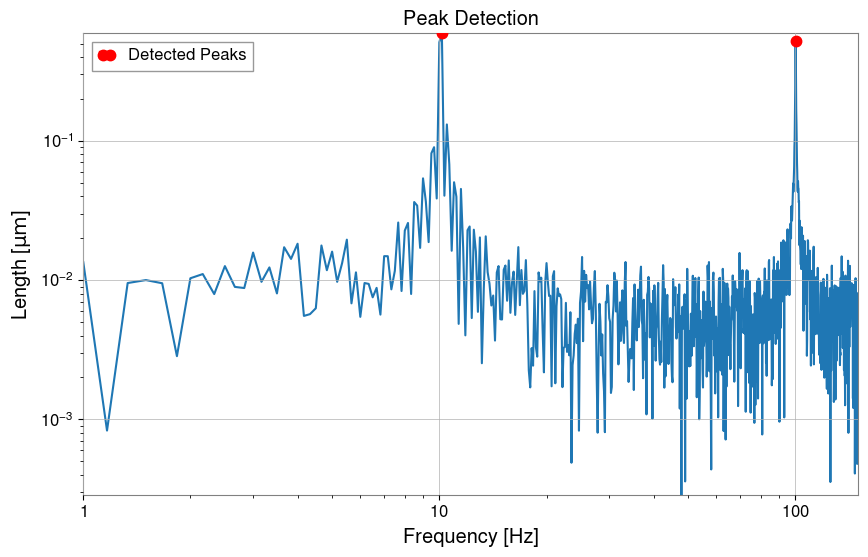

In [6]:
# 振幅 0.2 以上のピークを探す
peaks, props = spec.find_peaks(threshold=0.2)

plot = Plot(spec.abs())
ax = plot.gca()
ax.plot(
    peaks.abs(), color="red", marker=".", ms=15, lw=0, zorder=3, label="Detected Peaks"
)
ax.set_xlim(1, 150)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Peak Detection")
ax.legend()
plot.show()

## 5. 高度な解析機能

### 群遅延 (Group Delay)
`group_delay()` メソッドは、位相の周波数微分から群遅延（信号のエンベロープの遅延）を計算します。

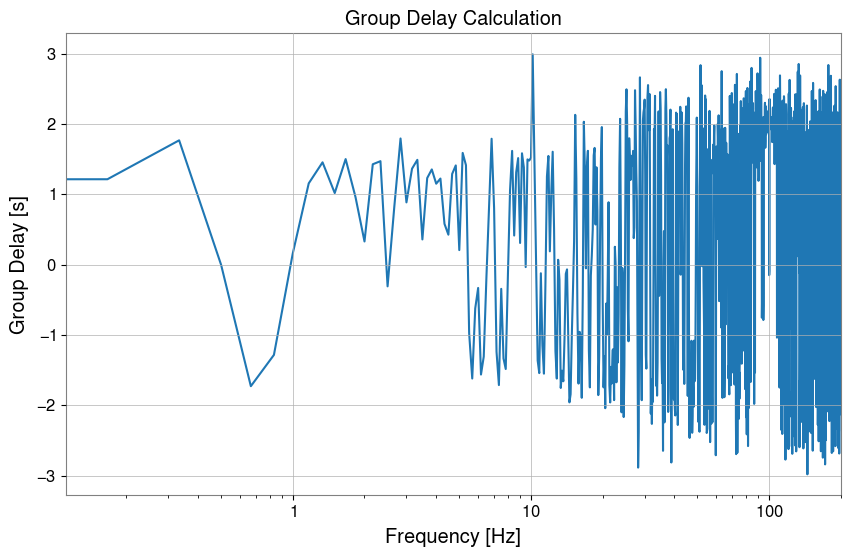

In [7]:
gd = spec.group_delay()

plot = Plot(gd)
ax = plot.gca()
ax.set_ylabel("Group Delay [s]")
ax.set_xlabel("Frequency [Hz]")
ax.set_xlim(0, 200)
ax.set_title("Group Delay Calculation")
plot.show()

### 逆FFT (ifft)
`ifft()` メソッドは、`TimeSeries` を返します。`mode="transient"` で FFT した結果であっても、情報を引き継いで元の長さに戻す (trim=True) などの制御が可能です。

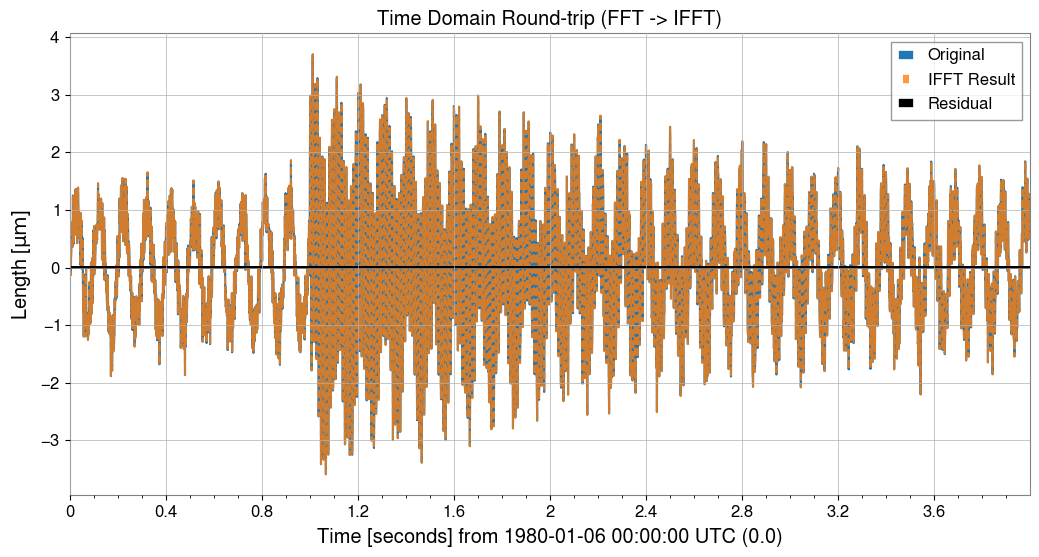

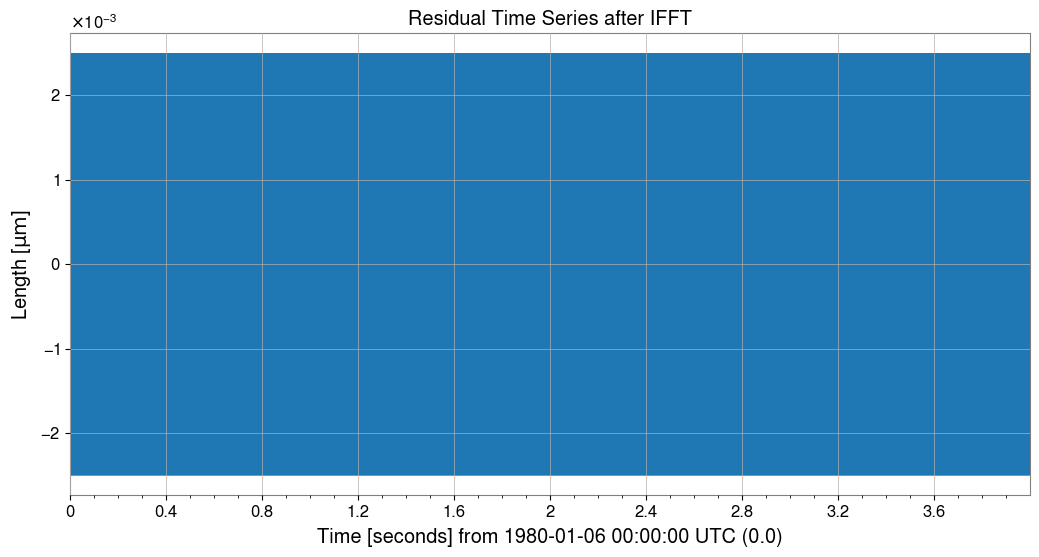

In [8]:
# 逆 FFT で TimeSeries に戻す
# mode="auto" は、入力 FrequencySeries が持つ transient 情報を読み取って適切に処理します
inv_ts = spec.ifft(mode="auto")
red_ts = inv_ts - ts

plot = Plot(ts, inv_ts, red_ts)
ax = plot.gca()
ax.get_lines()[0].set_label("Original")
ax.get_lines()[1].set_label("IFFT Result")
ax.get_lines()[2].set_label("Residual")
ax.get_lines()[1].set_linestyle("--")
ax.get_lines()[1].set_alpha(0.8)
ax.get_lines()[2].set_color("black")
ax.legend()
ax.set_title("Time Domain Round-trip (FFT -> IFFT)")
plot.show()

red_ts.plot(title="Residual Time Series after IFFT");

## 6. 他ライブラリとの連携

Pandas, xarray, control ライブラリとの相互変換が追加されています。

In [9]:
# Pandas Series へ変換
pd_series = spec.to_pandas()
print("Pandas index sample:", pd_series.index[:5])
display(pd_series)

# xarray DataArray へ変換
da = spec.to_xarray()
print("xarray coord name:", list(da.coords))
display(da)

# control.FRD へ変換 (制御系の解析に使用可能)
try:
    from control import FRD

    _ = FRD
    frd_obj = spec.to_control_frd()
    print("Successfully converted to control.FRD")
    display(frd_obj)
except ImportError:
    print("python-control library not installed")

Pandas index sample: Index([0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666], dtype='float64', name='frequency')


frequency
0.000000      0.005854+0.000000j
0.166667      0.008967+0.004633j
0.333333     -0.008449-0.005706j
0.500000     -0.016300+0.001454j
0.666667     -0.002042-0.001382j
                     ...        
511.333333    0.000634-0.007508j
511.500000   -0.000116+0.010886j
511.666667   -0.001983-0.011823j
511.833333   -0.004262+0.010238j
512.000000    0.004972+0.000000j
Name: Test Signal, Length: 3073, dtype: complex128

xarray coord name: ['frequency']


<xarray.DataArray 'Test Signal' (frequency: 3073)> Size: 49kB
array([ 0.00585353+0.j        ,  0.00896692+0.00463322j,
       -0.00844869-0.00570645j, ..., -0.00198317-0.01182314j,
       -0.00426223+0.01023835j,  0.00497225+0.j        ],
      shape=(3073,))
Coordinates:
  * frequency  (frequency) float64 25kB 0.0 0.1667 0.3333 ... 511.7 511.8 512.0
Attributes:
    unit:     um
    channel:  None
    epoch:    0.0

Successfully converted to control.FRD


FrequencyResponseData(
array([[[ 0.00585353+0.j        ,  0.00896692+0.00463322j,
         -0.00844869-0.00570645j, ...,
         -0.00198317-0.01182314j, -0.00426223+0.01023835j,
          0.00497225+0.j        ]]], shape=(1, 1, 3073)),
array([0.00000000e+00, 1.66666667e-01, 3.33333333e-01, ...,
       5.11666667e+02, 5.11833333e+02, 5.12000000e+02],
      shape=(3073,)),
outputs=1, inputs=1)

## 7. Python Control Library との連携

制御工学の分野で標準的な `control` ライブラリの **Frequency Response Data (FRD)** オブジェクトと相互変換が可能です。
これにより、GWExPyで計測した伝達関数を、制御系の設計や解析に直接利用できます。


--- Converted to Control FRD ---
<FrequencyResponseData>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

Freq [rad/s]  Response
------------  ---------------------
       0.000    0.005854        +0j
       0.167    0.008967 +0.004633j
       0.333   -0.008449 -0.005706j
       0.500     -0.0163 +0.001454j
       0.667   -0.002042 -0.001382j
       0.833    0.007545 +0.003096j
       1.000      0.0135 +0.001912j
       1.167   0.0008308+4.218e-05j
       1.333   -0.006241 -0.007206j
       1.500   -0.009913 -0.001403j
       1.667   -0.002726   +0.0091j
       1.833    0.002819+0.0003798j
       2.000     0.01019 -0.001586j
       2.167    0.009373 -0.005869j
       2.333   -0.007943+5.354e-05j
       2.500    -0.01105 +0.006091j
       2.667   -0.007186 -0.005324j
       2.833    0.005279 +0.007014j
       3.000     0.01578+0.0002709j
       3.167    0.005796 -0.007811j
       3.333     -0.0118 -0.003609j
       3.500   -0.004883 +0.006373j
       3.667    -0.01546 +0.007603j
   


--- Restored FrequencySeries ---
FrequencySeries([ 0.00585353+0.j        ,
                  0.00896692+0.00463322j,
                 -0.00844869-0.00570645j, ...,
                 -0.00198317-0.01182314j,
                 -0.00426223+0.01023835j,
                  0.00497225+0.j        ]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.02652582384864922 Hz,
                epoch: None,
                name: None,
                channel: None)


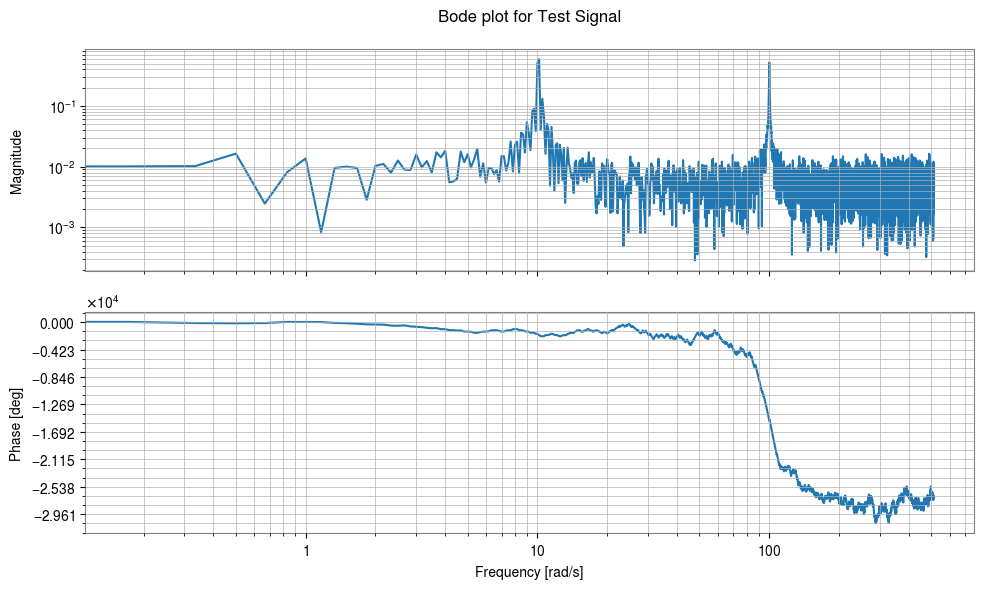

In [10]:
try:
    import control

    # FrequencySeries -> control.FRD 変換
    # frequency_unit="Hz" を指定すると、内部で rad/s に適切に変換して渡します
    frd_sys = spec.to_control_frd(frequency_unit="Hz")

    print("\n--- Converted to Control FRD ---")
    print(str(frd_sys)[:1000] + "\n... (truncated) ...")

    # ボード線図のプロット (controlライブラリの機能)
    control.bode(frd_sys)  # (プロット環境があれば実行可能)

    # control.FRD -> FrequencySeries 復元
    fs_restored = FrequencySeries.from_control_frd(frd_sys, frequency_unit="Hz")

    print("\n--- Restored FrequencySeries ---")
    print(fs_restored)

except ImportError:
    print("Python Control Systems Library is not installed.")

## 8. 求積和 (Quadrature Sum)

直交位相の和を計算する機能です。

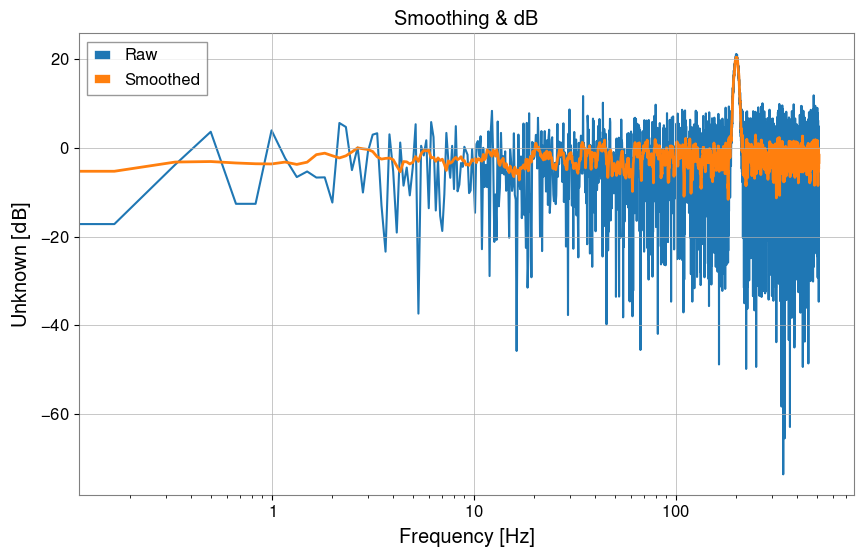

Noise A: 1.0, Noise B: 2.0
Total (Sqrt Sum): 2.23606797749979


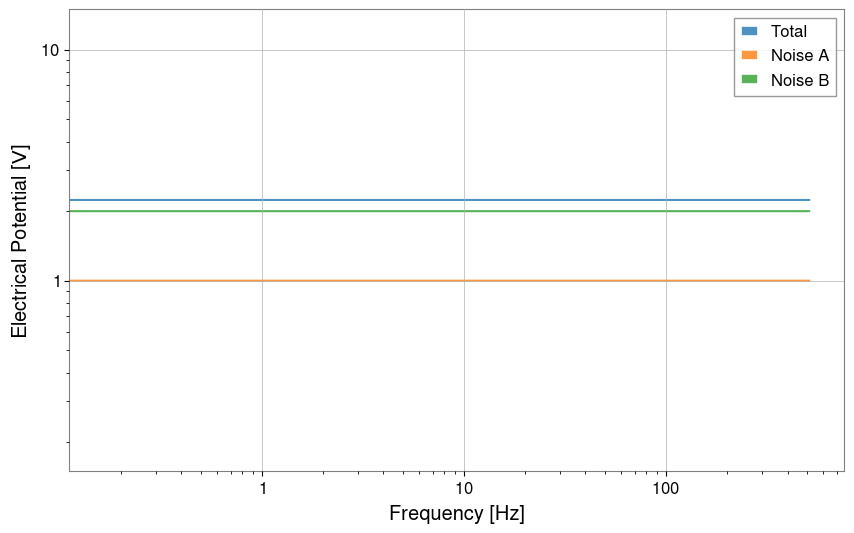

In [11]:
# Generate noisy data
np.random.seed(42)
f = spec.frequencies.value
noise = np.abs(np.random.randn(f.size))
peak = 10.0 * np.exp(-((f - 200) ** 2) / 50.0)
data = noise + peak

raw = FrequencySeries(data, frequencies=f, unit="V", name="Raw Data")

# Smooth
smoothed = raw.smooth(width=10, method="amplitude")
smoothed.name = "Smoothed"

# Convert to dB
raw_db = raw.to_db()
smoothed_db = smoothed.to_db()
raw_db.name = "Raw (dB)"
smoothed_db.name = "Smoothed (dB)"

plot = raw_db.plot(label="Raw", title="Smoothing & dB")
ax = plot.gca()
ax.plot(smoothed_db, label="Smoothed", linewidth=2)
ax.legend()
plot.show()
plt.close()

# Quadrature Sum (Noise Budget example)
noise_a = FrequencySeries(np.ones_like(f), frequencies=f, unit="V", name="Noise A")
noise_b = FrequencySeries(np.ones_like(f) * 2, frequencies=f, unit="V", name="Noise B")

total = noise_a.quadrature_sum(noise_b)
print(f"Noise A: {noise_a.value[0]}, Noise B: {noise_b.value[0]}")
print(f"Total (Sqrt Sum): {total.value[0]}")
Plot(total, noise_a, noise_b, alpha=0.8)
plt.legend(["Total", "Noise A", "Noise B"])
plt.xscale("log")
plt.yscale("log")
plt.show()